In [1]:
# leba3207

import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import DBSCAN
from itertools import product

In [2]:
# Chargement d'un ensemble de données de faces de personnages connus
from sklearn.datasets import fetch_lfw_people

In [3]:
import os, ssl

if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
        getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
faces = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [5]:
# format des images et nombres de clusters
print("Format des images: {}".format(faces.images.shape))
print("Nombre de classes: {}".format(len(faces.target_names)))

Format des images: (3023, 87, 65)
Nombre de classes: 62


In [6]:
# nombre de données par cluster
number_target_per_face = np.bincount(faces.target)
for i, (nb, nom) in enumerate(zip(number_target_per_face, faces.target_names)):
    print("{0:25} {1:3}".format(nom, nb), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

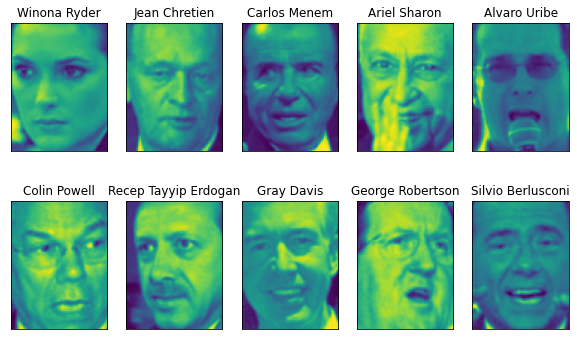

In [7]:
# Affichage des 10 premières faces
fig, axes = plt.subplots(2, 5, figsize=(10, 6), subplot_kw={'xticks': (), 'yticks': ()})
for nom, image, ax in zip(faces.target, faces.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(faces.target_names[nom])

# 1. Balancement des données

In [8]:

data = pd.DataFrame(faces.data)

In [9]:

filtered_faces = dict()
filtered_data = pd.DataFrame()
filtered_target = []
for i, (tn, nb) in enumerate(zip(faces.target_names, number_target_per_face)):
    # retrieve first forty indexes of target associated
    positions = np.where(faces.target == i)[0][:40]

    filtered_faces[tn] = []
    for p in positions:
        filtered_faces[tn].append(faces.images[p])

        filtered_data.loc[:, p] = data.iloc[p]
        filtered_target.append(faces.target[p])

filtered_data = filtered_data.T

# 2. Réduction de la dimensionalité des données

In [10]:

pca = PCA(n_components=100, whiten=True, random_state=0)
reduced_data = pd.DataFrame(pca.fit_transform(filtered_data), index=filtered_data.index)

# 3. Analyse avec K-Means
## a. Méthode Elbow

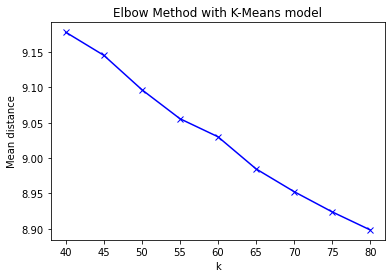

In [11]:
K = range(40, 85, 5)
mean_distances = []
for k in K:
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(reduced_data)
    dist_to_best_centroid = np.min(cdist(reduced_data, model.cluster_centers_, 'euclidean'), axis=1)
    mean_distances.append(sum(dist_to_best_centroid) / reduced_data.shape[0])

plt.plot(K, mean_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Mean distance')
plt.title('Elbow Method with K-Means model')
plt.show()

## b. Approche de validation croisée

In [ ]:

mean_scores = []
for k in K:
    scorer = make_scorer(adjusted_rand_score)
    model = KMeans(n_clusters=k, random_state=0)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    cv_results = cross_validate(model, reduced_data, filtered_target, cv=cv, scoring=scorer, n_jobs=-1)
    mean_scores.append(np.mean(cv_results['test_score']))

plt.plot(K, mean_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Mean score')
plt.title('Cross validation with K-Means model')
plt.show()

# 4. Analyse avec DBSCAN
## a. Utilisation du coefficient de silhouette

In [13]:

pairwise_dist = squareform(pdist(reduced_data, 'euclidean'))
best_params = {'score': 0}
for i, (ep, min_sample) in enumerate(product(range(5, 16), range(1, 11))):
    model = DBSCAN(eps=ep, min_samples=min_sample, n_jobs=-1)
    pred = model.fit_predict(reduced_data, filtered_target)

    if len(np.unique(pred)) != 1:
        score = silhouette_score(pairwise_dist, pred)

        if score > best_params.get('score'):
            best_params['eps'] = ep
            best_params['min_sample'] = min_sample
            best_params['score'] = score
            best_params['model'] = model

print(f'Les paramètres présentant les meilleurs silhouette score sont: eps {best_params.get("eps")} et min_sample '
      f'{best_params.get("min_sample")}')
print(f'Le nombre de clusters trouvé est de {len(np.unique(model.labels_)) - 1}')

Les paramètres présentant les meilleurs silhouette score sont: eps 15 et min_sample 3
Le nombre de clusters trouvé est de 1


## b. Visualisation

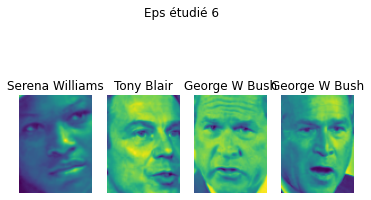

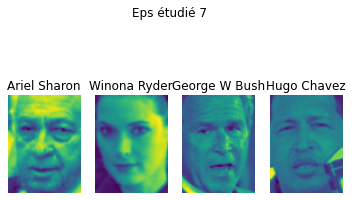

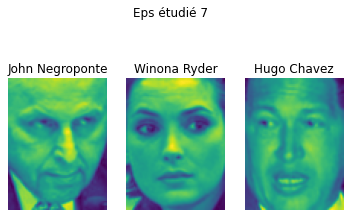

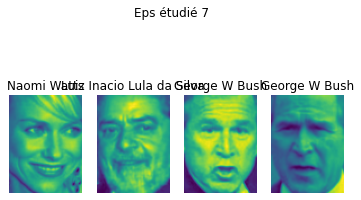

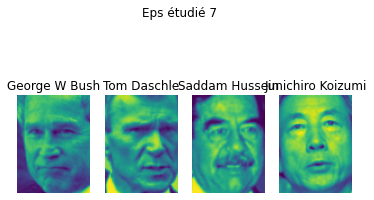

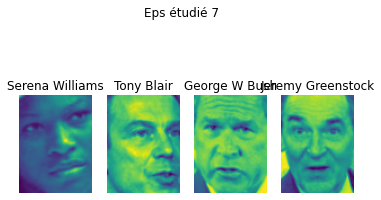

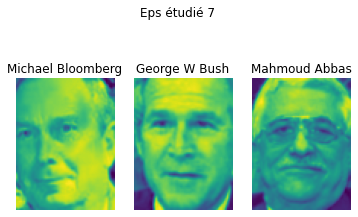

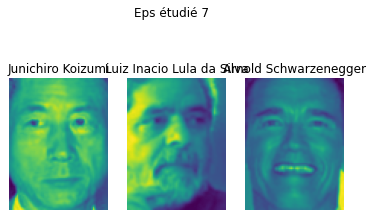

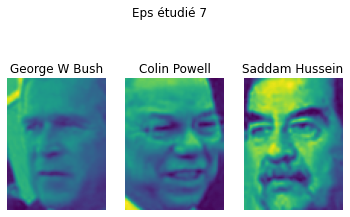

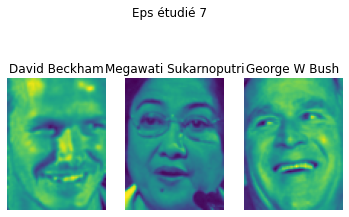

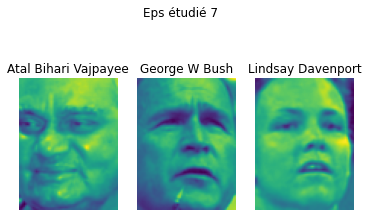

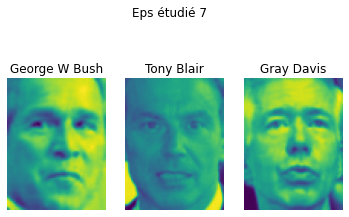

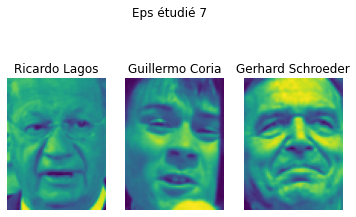

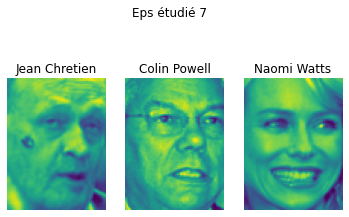

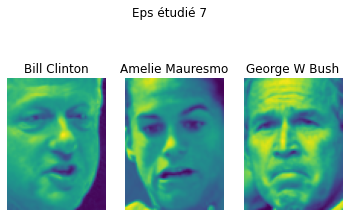

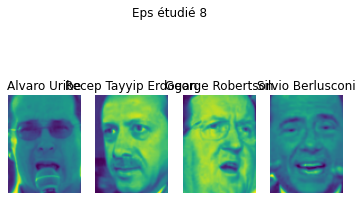

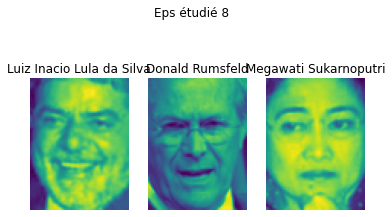

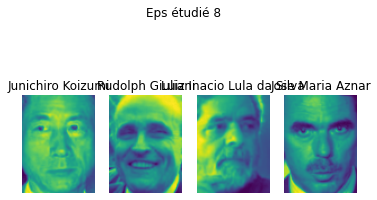

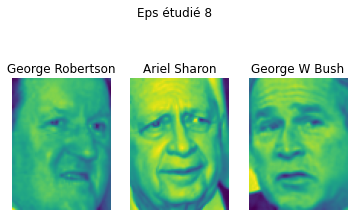

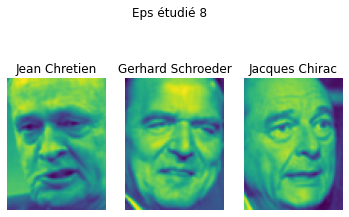

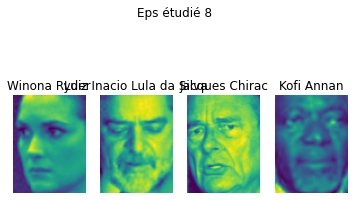

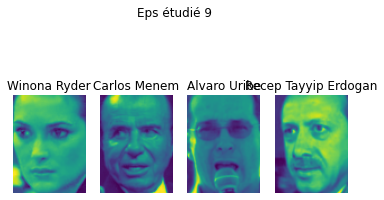

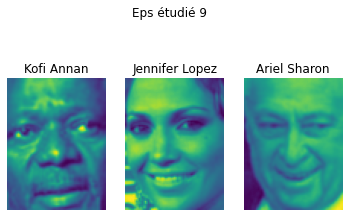

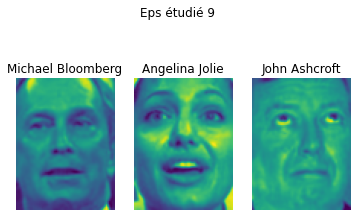

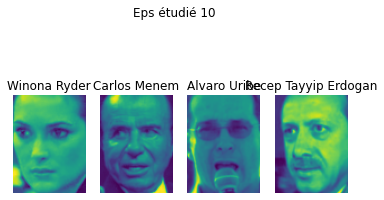

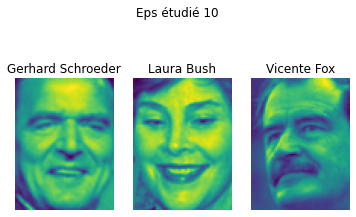

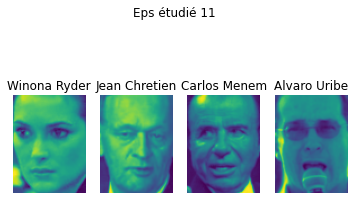

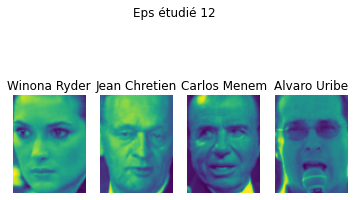

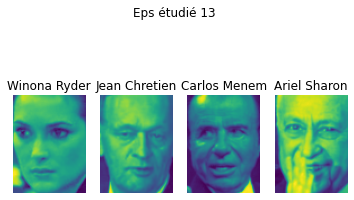

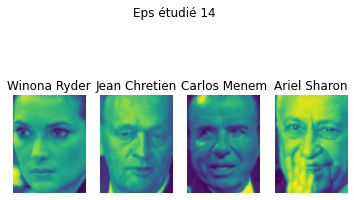

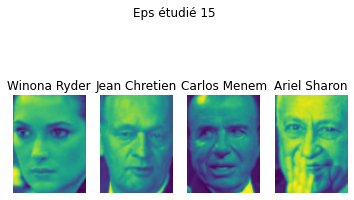

In [14]:

min_samples = 3

for eps in range(5, 16):
    model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    pred = model.fit_predict(reduced_data, filtered_target)
    labels = np.unique(model.labels_)
    for label in labels[labels != -1]:  # cluster -1 (noise) not considered
        positions = np.where(pred == label)
        cpt, clusters_images, clusters_names = 0, [], []
        for p in positions[0]:
            if cpt >= 4:
                break
            clusters_images.append(faces.images[p])
            clusters_names.append(faces.target_names[faces.target[p]])
            cpt += 1

        fig, axs = plt.subplots(nrows=1, ncols=len(clusters_images))
        for img, name, ax in zip(clusters_images, clusters_names, axs):
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(name)
        fig.suptitle(f'Eps étudié {eps}')
        plt.show()